# SENTIMENT ANALYSIS USING TRANSFER LEARNING

## Word2Vec pre-train the embedding vectors on a very large dataset

### CBOW -> Continous Bag Of Words

![CBOW](https://media.geeksforgeeks.org/wp-content/uploads/cbow-1.png)

### Skip-Gram



![Skip-Gram](https://media.geeksforgeeks.org/wp-content/uploads/skip_gram.png)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import regex as re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import gensim.downloader as api

## DATA PREPARATION

In [2]:
trainDS, valDS, testDS = tfds.load('imdb_reviews',
                                   split=['train', 'test[:50%]', 'test[50%:]'],
                                   as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XDDIVX_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XDDIVX_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.XDDIVX_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
len(trainDS), len(valDS), len(testDS)

(25000, 12500, 12500)

In [4]:
for review, label in trainDS.take(2):
    print('Review:', review.numpy())
    print('Label:', label.numpy())
    print('\n')

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbis

In [5]:
def standardization(inputData):
    lowerCaseOutput = tf.strings.lower(inputData)
    noTagOutput = tf.strings.regex_replace(lowerCaseOutput, "<[^>]+>", " ")
    noPunctOutput = tf.strings.regex_replace(noTagOutput, "[%s]" % re.escape(string.punctuation), "")
    return noPunctOutput

In [6]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

In [7]:
vectorizer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQUENCE_LENGTH,
    output_mode='int',
)

In [8]:
trainingData = trainDS.map(lambda x, y: x)
vectorizer.adapt(trainingData)

In [9]:
def vectorize(review, label):
    return vectorizer(review), label

In [10]:
trainDS = trainDS.map(vectorize)
valDS = valDS.map(vectorize)

In [11]:
for review, label in trainDS.take(1):
    print('Review:', review.numpy())
    print('Label:', label.numpy())
    print('\n')

Review: [  11   13   33  414  380   17   89   26    1    8   32 1336 3543   41
  489    1  190   23   84  151   18   11  219  318   26   64  241  211
    8  476   53   64   84  111   97   21 5574   11   92  633  729   11
   17    7   33  396 9231  167 2462  408    2   88 1192  135   65  143
   51    2    1 7488   65  247   64 2835   15    1 2869    1    1 1436
 4861    3   39    1 1546   16 3543   13  156   18    4 1192  894 7958
    8    4   17   12   13 4064    5   99  146 1229   10  236  663   12
   47   23   92   38   11 7269  151   38 1336    1   49  397   10   97
 1170  856  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [12]:
BATCH_SIZE = 64
trainDS = trainDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDS = valDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## MODELING & TRAINING

### Word2Vec Transfer Learning

In [16]:
EMBEDDING_DIM = 300

In [13]:
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [14]:
word2vec.vectors.shape

(3000000, 300)

In [15]:
word2vec.most_similar('love')

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('Ilove', 0.5702950954437256),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063)]

In [17]:
def firstCaps(word):
  return word[0].upper() + word[1:]

In [18]:
pretrainedEmbeddings = []
for i in range(len(vectorizer.get_vocabulary())):
    try:
        pretrainedEmbeddings.append(word2vec[vectorizer.get_vocabulary()[i]])
    except:
        print(vectorizer.get_vocabulary()[i])
        try:
            pretrainedEmbeddings.append(word2vec[firstCaps(vectorizer.get_vocabulary()[i])])
        except:
            pretrainedEmbeddings.append(np.random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))


[UNK]
and
a
of
to
doesnt
didnt
isnt
wasnt
10
80s
20
70s
12
15
30
humour
100
hasnt
90
shouldnt
favourite
theatre
60s
40
tarzan
lowbudget
50
1010
1950s
90s
welles
keaton
50s
810
11
1970s
710
overthetop
sinatra
columbo
1980s
25
13
1930s
bmovie
14
aint
110
pacino
writerdirector
410
310
lugosi
hitchcock
910
1960s
2006
30s
2000
wwii
grey
bettie
sandler
widmark
2001
mst3k
stanwyck
seagal
matthau
colour
branagh
18
denzel
80
17
45
realise
mustsee
brando
24
2005
40s
walken
karloff
911
210
heston
elvira
flynn
streisand
ritter
spielberg
20th
eyre
cagney
cusack
astaire
carrey
brosnan
2004
2003
60
mildred
16
hollywoods
falk
2002
1990s
uwe
paulie
voight
eastwood
1999
orson
lemmon
2007
1996
onedimensional
madefortv
1980
miike
fonda
disneys
70
streep
beatty
3000
1990
1972
niro
gundam
carradine
1968
1940s
paltrow
bakshi
amitabh
1983
bacall
13th
polanski
lumet
dolph
1973
–
whoopi
verhoeven
othello
kubrick
bergman
35
1971
ramones
meryl
christy
timon
romero
fulci
1984
1987
raines
favour
barrymore
antwone


In [19]:
pretrainedEmbeddings = np.array(pretrainedEmbeddings)
pretrainedEmbeddings.shape

(10000, 300)

In [21]:
np.save('WordEmbeddings/pretrainedEmbeddings.npy', pretrainedEmbeddings)

In [22]:
pretrainedEmbeddings = np.load('WordEmbeddings/pretrainedEmbeddings.npy')
pretrainedEmbeddings.shape

(10000, 300)

## Using Conv1D Model for Sentiment Analysis with Word2Vec Embeddings

In [30]:
convModel = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE,
                              EMBEDDING_DIM,
                              embeddings_initializer = tf.keras.initializers.Constant(pretrainedEmbeddings),
                              trainable=False),

    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name = "convModel")
convModel.summary()

Model: "convModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,029,921 (11.56 MB)

 Trainable params: 29,921 (116.88 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [26]:
! mkdir Models

In [31]:
checkpointFilepath = 'Models/convModel(Word2Vec).h5'
modelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpointFilepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [32]:
convModel.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = convModel.fit(
    trainDS,
    validation_data=valDS,
    epochs=10,
    callbacks=[modelCheckpointCallback]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5645 - loss: 0.6755

391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.5647 - loss: 0.6754 - val_accuracy: 0.7926 - val_loss: 0.4955
Epoch 2/10
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7912 - loss: 0.4781

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.7913 - loss: 0.4780 - val_accuracy: 0.8249 - val_loss: 0.4126
Epoch 3/10
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8234 - loss: 0.4171

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8235 - loss: 0.4171 - val_accuracy: 0.8352 - val_loss: 0.3877
Epoch 4/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8365 - loss: 0.3936

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8365 - loss: 0.3935 - val_accuracy: 0.8426 - val_loss: 0.3704
Epoch 5/10
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8456 - loss: 0.3780

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8456 - loss: 0.3780 - val_accuracy: 0.8478 - val_loss: 0.3588
Epoch 6/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8501 - loss: 0.3599

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8501 - loss: 0.3599 - val_accuracy: 0.8535 - val_loss: 0.3448
Epoch 7/10
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8548 - loss: 0.3500

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8548 - loss: 0.3500 - val_accuracy: 0.8559 - val_loss: 0.3369
Epoch 8/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8601 - loss: 0.3429

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8601 - loss: 0.3429 - val_accuracy: 0.8581 - val_loss: 0.3307
Epoch 9/10
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8629 - loss: 0.3377

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8629 - loss: 0.3377 - val_accuracy: 0.8614 - val_loss: 0.3243
Epoch 10/10
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8661 - loss: 0.3301

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8661 - loss: 0.3301 - val_accuracy: 0.8625 - val_loss: 0.3236


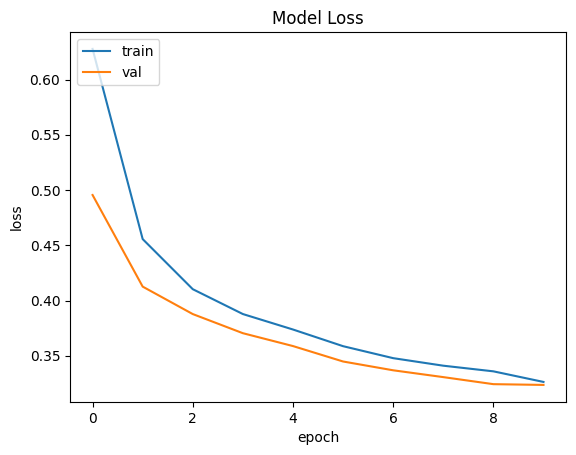

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

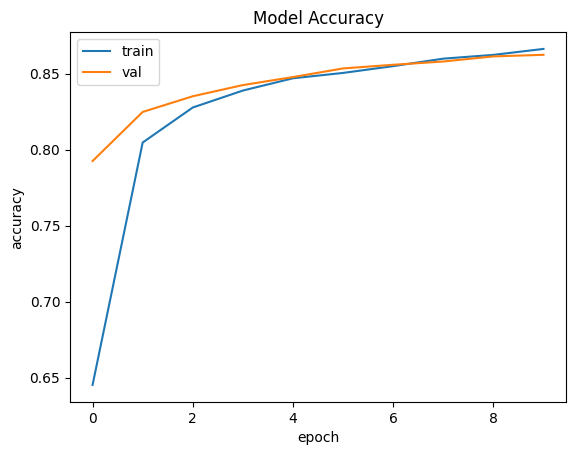

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
testDS = testDS.map(vectorize)
testDS = testDS.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testLoss, testAccuracy = convModel.evaluate(testDS)
print('Test Loss:', testLoss)
print('Test Accuracy:', testAccuracy)

196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8587 - loss: 0.3244
Test Loss: 0.32726576924324036
Test Accuracy: 0.8568800091743469
